# Cropped Masked Autoencoders: Reconstruction Demo
Inspired by the [MAE Visualization Demo](https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb)

## Dependencies

In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone "https://github.com/Kimiko-AI/CropMAE"
    !pip3 install "timm==0.9.16"
    sys.path.append('./CropMAE')
else:
    !pip3 install -r "requirements.txt"

!pip3 install "gdown" # for downloading files from google drive

Cloning into 'CropMAE'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 280 (delta 4), reused 5 (delta 0), pack-reused 244 (from 1)
Receiving objects: 100% (280/280), 3.59 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (113/113), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12


In [1]:
%cd /content/CropMAE

from matplotlib import pyplot as plt
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from PIL import Image
import numpy as np
import torch
import requests
import pathlib
import gdown

from models.SiamMAE import SIAM_MODELS
import misc.util as util
from data.util import GlobalToLocal, LocalToGlobal, RandomViews, SameViews

/content/CropMAE


## Utils

In [2]:
def get_default_config():
    # We load the default configuration for CropMAE
    return util.get_args_parser().parse_known_args()[0]

def pil_to_tensor(pil_img, img_size=(448, 448)):

    img = pil_img.resize(img_size)
    img = np.array(img) / 255.

    # normalize by ImageNet mean and std
    img = img - np.array(IMAGENET_DEFAULT_MEAN)
    img = img / np.array(IMAGENET_DEFAULT_STD)

    return torch.tensor(img)

def show_image(image, title=""):
    assert image.shape[2] == 3 # image is [H, W, 3]
    plt.imshow(torch.clip((image * np.array(IMAGENET_DEFAULT_STD) + np.array(IMAGENET_DEFAULT_MEAN)) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def prepare_model(chkpt_dir, backbone='vits_16'):
    model_size, patch_size = backbone.split('_')
    patch_size = int(patch_size)
    model = SIAM_MODELS[model_size](patch_size=patch_size)
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    status = model.load_state_dict(checkpoint['model'], strict=False)
    print(f"Model Loading Status: {status}")
    return model

def run_one_image(img, model, crop_strategy=GlobalToLocal, mask_ratio=0.75):

    # Use default CropMAE configuration
    config = get_default_config()

    # Generate both views `v1`, `v2` from the initial image `img` and make them batch-like
    v1, v2 = crop_strategy(config)(img)
    v1, v2 = v1.unsqueeze(0), v2.unsqueeze(0)
    v1v2 = torch.cat([v1, v2], dim=0).unsqueeze(0)

    # Run CropMAE
    loss, masked_preds, masked_masks = model(v1v2.float(), mask_ratio=mask_ratio)

    # Reassemble the patches of the reconstruction of v2
    rec_v2 = model.unpatchify(masked_preds[0])
    rec_v2 = torch.einsum('nchw->nhwc', rec_v2).detach().cpu()

    # Create the mask for v2
    mask_v2 = masked_masks[0].detach()
    mask_v2 = mask_v2.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)
    mask_v2 = model.unpatchify(mask_v2)
    mask_v2 = torch.einsum('nchw->nhwc', mask_v2).detach().cpu()

    # Apply the mask to v2
    v2 = torch.einsum('nchw->nhwc', v2)
    v2_masked = v2 * (1. - mask_v2)

    # Paste the reconstruction of v2 on the original visible patches of v2
    im_paste = v2 * (1 - mask_v2) + rec_v2 * mask_v2

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [18, 18]

    print("Creation of the views:")
    plt.subplot(1, 3, 1)
    show_image(pil_to_tensor(img), "Original")

    plt.subplot(1, 3, 2)
    show_image(v1[0].permute(1, 2, 0), "V1")

    plt.subplot(1, 3, 3)
    show_image(v2[0], "V2")

    plt.tight_layout()
    plt.show()

    print("Reconstruction:")
    plt.subplot(1, 3, 1)
    show_image(v2_masked[0], f"V2 Masked at {mask_ratio*100:.2f}%")

    plt.subplot(1, 3, 2)
    show_image(rec_v2[0], "V2 Reconstructed from V1")

    plt.subplot(1, 3, 3)
    show_image(im_paste[0], "V2 Reconstructed from V1 + Visible")

    plt.tight_layout()
    plt.show()

In [3]:
get_default_config()

Namespace(input_size=448, architecture='vits', decoder_embed_dim=256, decoder_depth=4, decoder_num_heads=8, masking_ratio=0.985, patch_size=16, norm_pix_loss=False, batch_size=128, max_files=None, accum_iter=1, wandb='online', wandb_run_name='', save_every_n=10, log_per_epoch=2, weight_decay=0.05, betas='0.9,0.95', lr=None, blr=5e-05, min_lr_prop=0.0, epochs=400, start_epoch=0, warmup_epochs_prop=0.05, resume='', random_area_min_global=0.2, random_area_max_global=1.0, random_area_min_local=0.2, random_area_max_local=1.0, use_color_jitter=False, use_gaussian_blur=False, use_elastic_transform=False, random_aspect_ratio_min_global=0.75, random_aspect_ratio_max_global=1.3333333333333333, random_aspect_ratio_min_local=0.75, random_aspect_ratio_max_local=1.3333333333333333, repeated_sampling_factor=1, crop_strategy='GlobalToLocal', interpolation_method='bilinear', horizontal_flip_p=0.5, data_path='k400_true_valid_files.txt', output_dir='./output_dir', log_dir='./output_dir', device='cuda', s

## Load Image

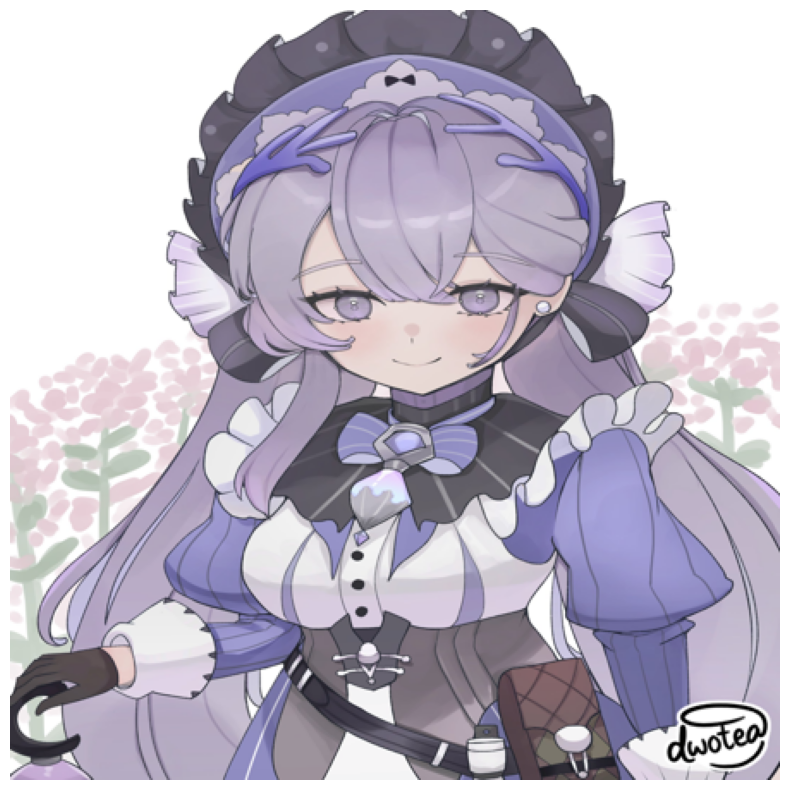

In [8]:
# load an image
img_url = 'https://cdn.donmai.us/original/06/1a/__rosemary_wuthering_waves_drawn_by_dwotea__061a9796e24bbbf68a82d7d82ae60539.jpg' # fox, from ILSVRC2012_val_00046145
#img_url = 'https://cdn.donmai.us/sample/43/31/__baobhan_sith_and_baobhan_sith_fate_and_1_more_drawn_by_trashochist__sample-4331e32e31ba93fbaf9520963671c36a.jpg' # cucumber, from ILSVRC2012_val_00047851
pil_img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
img = pil_to_tensor(pil_img)

plt.rcParams['figure.figsize'] = [10, 10]
show_image(img)

## Load pre-trained Model

**NOTE:** In the paper, the model was trained to predict the normalized pixel values of missing patches. In contrast, here, we train a model to predict the non-normalized pixel values. This approach makes it easier to demonstrate the model's effectiveness in reconstructing the masked view.

In [9]:
%cd /content
#!wget https://huggingface.co/Shio-Koube/Anime-girl-viewer-9000/resolve/main/checkpoint-56.pth
import torch

# Load the .pth file
checkpoint = torch.load('/content/checkpoint-56.pth', map_location=torch.device('cpu'))


for key in list(checkpoint['model'].keys()):
    checkpoint['model'][key.replace("_orig_mod.", "")] = checkpoint["model"].pop(key)

torch.save(checkpoint, 'renamed.pth')


/content


<ipython-input-9-51714506019b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/checkpoint-56.pth', map_location=torch.device('cpu'))


In [10]:
model = prepare_model("/content/renamed.pth", 'vits_16')


SiamMAE with: Decoder Embed Dim: 256, Decoder Depth: 6, Decoder Num Heads: 8


<ipython-input-2-8299db239cc3>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


Model Loading Status: <All keys matched successfully>


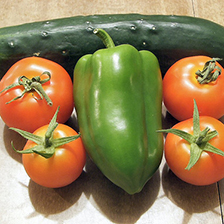

In [11]:
pil_img

## Run CropMAE
CropMAE works by creating two views $V_1, V_2$ from an input image $I$ by following a particular cropping strategy (refer to the paper).

The second view $V_2$ is masked at a very high ratio, typically 98.5%, and reconstructed by the network, which has access to $V_1$ to do so.

Creation of the views:


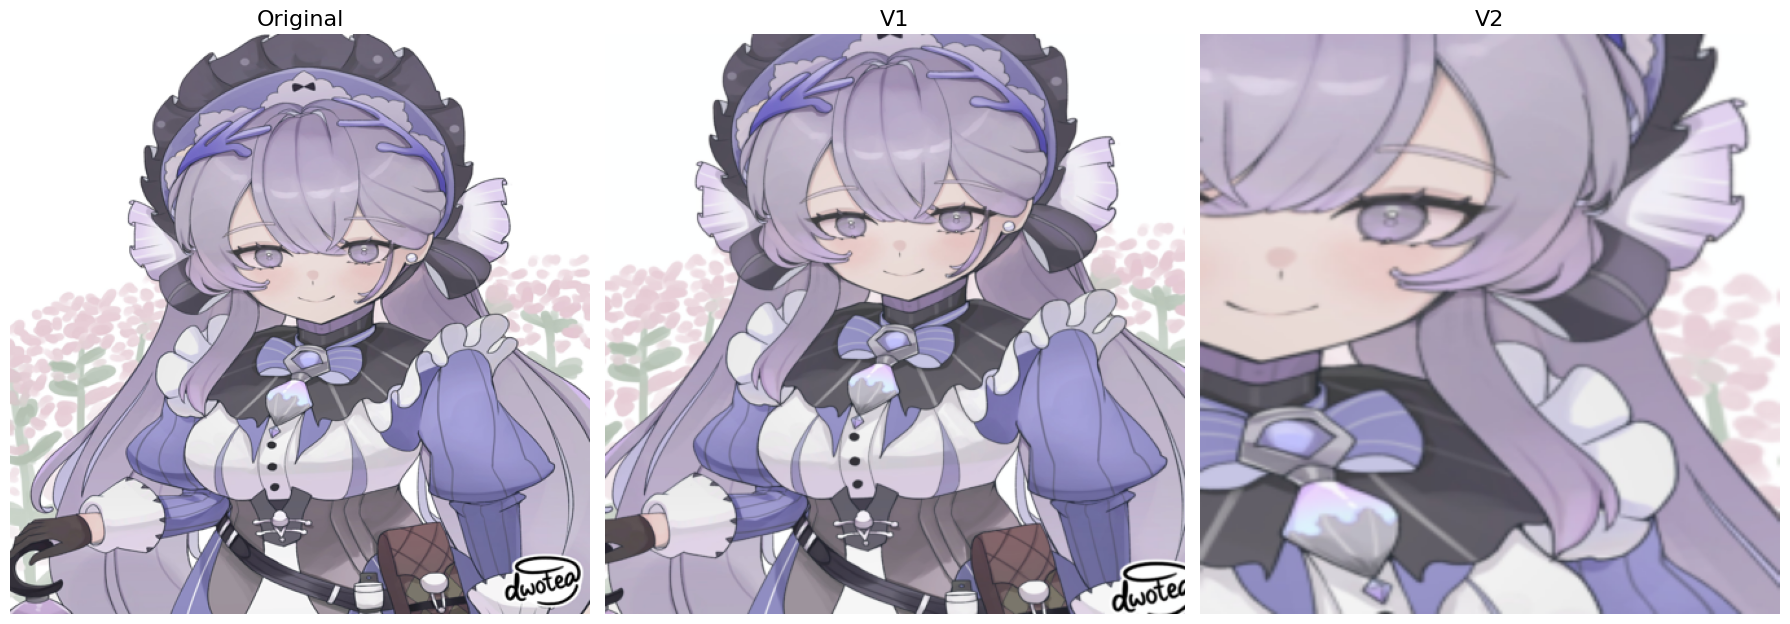

Reconstruction:


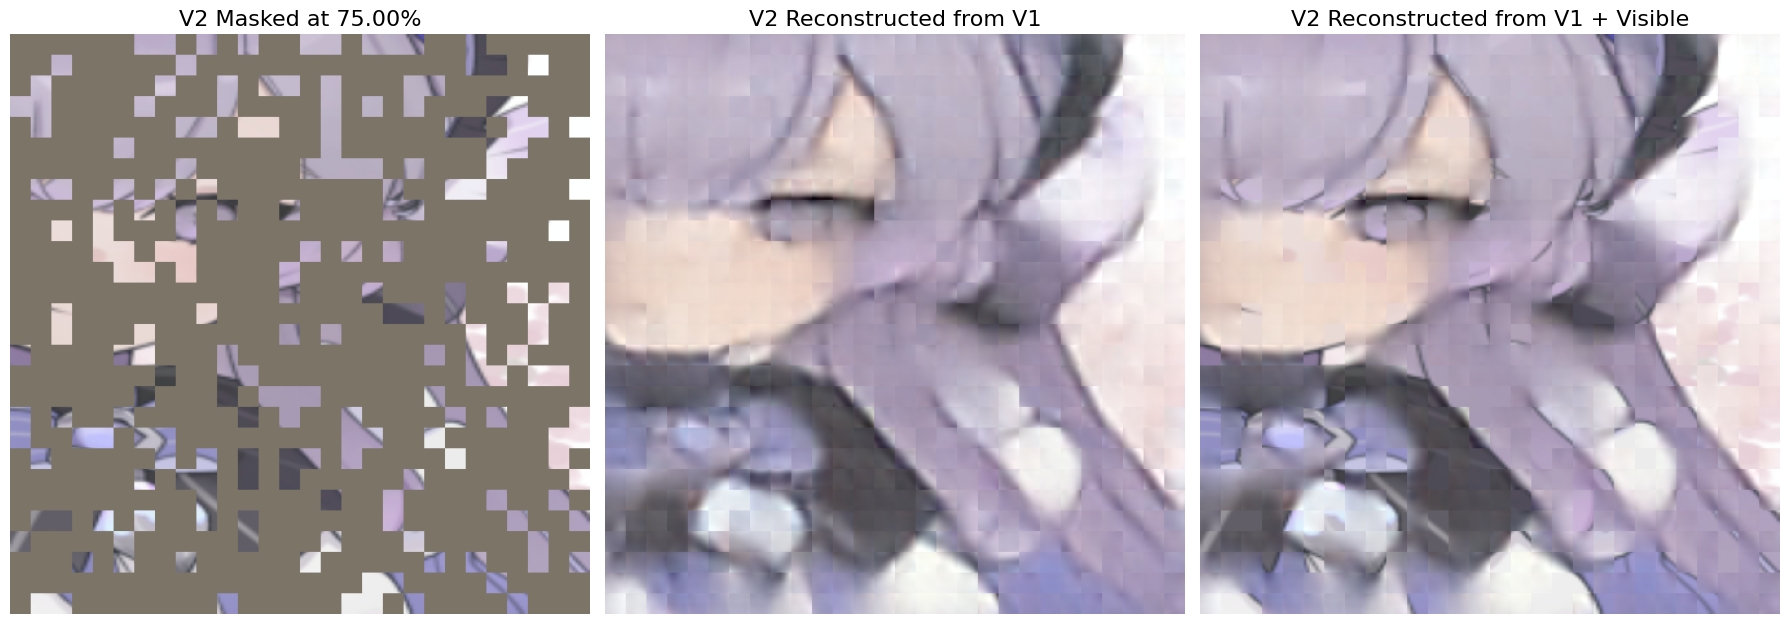

In [11]:
# Make random mask reproducible (comment out to make it change)
#torch.manual_seed(42)
run_one_image(pil_img, model)